In [2]:
import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from plotting_utils.plot_distributions import plot_distributions
# from utils.data_loader import *

In [3]:
# Read in the data
data_root = '/mnt/mnemo5/sum02dean/sl_projects/MLG/task_1/data/CAGE-train'
files_train = glob.glob(os.path.join(data_root, '*train_y.tsv'))
files_val = glob.glob(os.path.join(data_root, '*val_y.tsv'))

# Get train and test
df_train = pd.concat([pd.read_csv(x, sep='\t') for x in files_train])
df_val= pd.concat([pd.read_csv(x, sep='\t') for x in files_val])



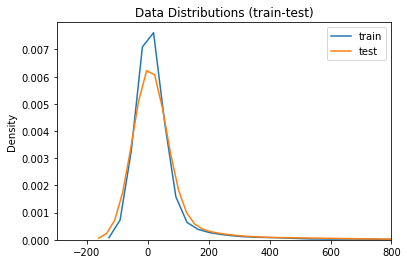

In [4]:
# Show the overlap in global train-test
plot_distributions(df_train.gex, df_val.gex, names=['train', 'test'])

In [6]:
files_x1 = glob.glob(os.path.join(data_root, 'X1_train_y.tsv'))
files_x2 = glob.glob(os.path.join(data_root, 'X2_train.tsv'))

In [ ]:
df_x1 = pd.read_csv(files_x1)
df_x2 = pd.read_csv(files_x2)

In [7]:
files_x1

['/mnt/mnemo5/sum02dean/sl_projects/MLG/task_1/data/CAGE-train/X1_train_y.tsv']

In [1]:
pd.read_csv(files_x1)

NameError: name 'pd' is not defined